<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/PWM_SineTriangle_VaryingReference_aligned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Pulse Width Modulation - Varying Modulation Function with Edges Aligned</h1></b>

Dr. Bingsen Wang

11/23/2023
</center>

#Python Code
The Python code illustrates the basic PWM when the modulation function varies.  

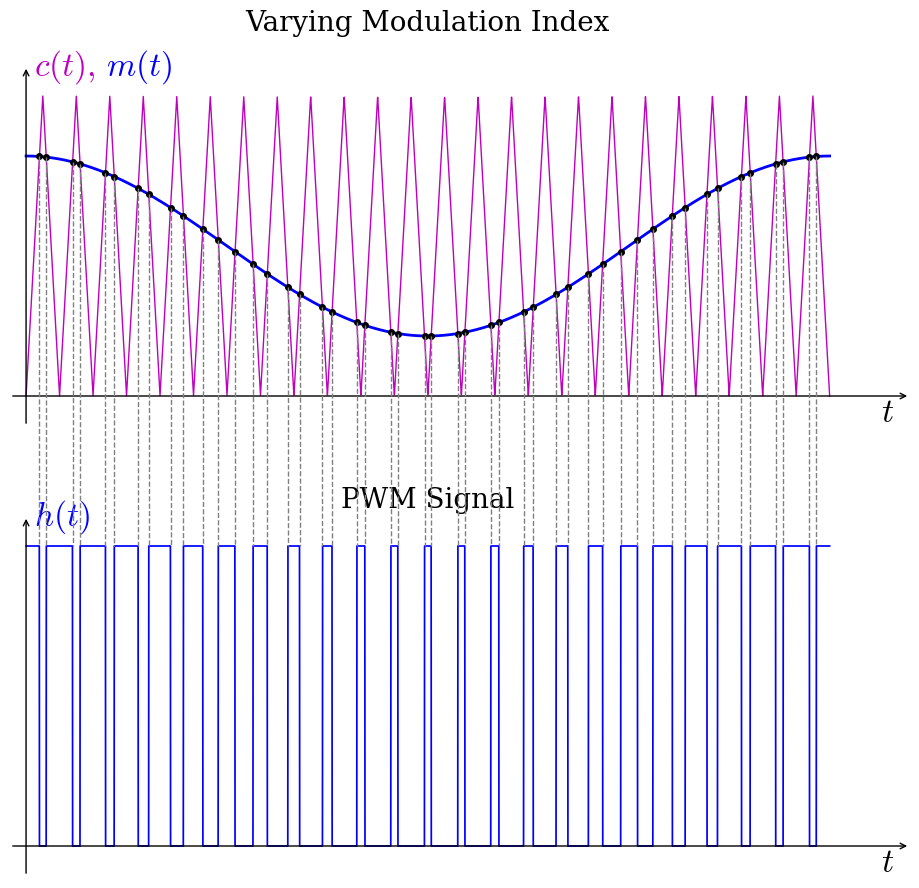

In [16]:
import matplotlib
from os import linesep
from numpy import linspace,cos,pi,sin,random,arccos,heaviside,array
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib import animation,rc
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

#functions
def carr(f,t): #carrier
  return 1/pi*arccos(cos(2*pi*f*t))

def m(MI,f,theta,t): #modulation function
  return (MI*cos(2*pi*f*t + theta) + 1)/2

def h(ct,mt): #PWM switching function
  return heaviside(mt-ct,0)

# define the function to be solved
def y(x,*data):
  MI,fm,theta,fc = data
  return m(MI,fm,theta,x) -carr(fc,x)

#solving for intersection points
def intersectionPoints(MI,fm,theta,fc):
  ts=[] #list for intersection points
  for k in range(fc):
    ts.append(fsolve(y,1/fc*(0.25+k),args=(MI,fm,theta,fc))[0])
    ts.append(fsolve(y,1/fc*(0.75+k),args=(MI,fm,theta,fc))[0])
  ts=array(ts)
  mts = m(MI,fm,theta,ts) # m(t) values at intersection points
  return ts,mts

# draw dotted line between two sets of points in two different plots
def l2Ax(fig,ps1,ps2):
  line_set = []
  transFigure = fig.transFigure.inverted()
  for k in range(len(ps1[0])):
    p1 = transFigure.transform(ax_lst[0].transData.transform([ps1[0][k],ps1[1][k]]))
    p2 = transFigure.transform(ax_lst[1].transData.transform([ps2[0][k],ps2[1][k]]))
    line = matplotlib.lines.Line2D((p1[0],p2[0]),(p1[1],p2[1]),
                      transform=fig.transFigure,ls='--',color='gray', lw=1)
    line_set.append(line)
  fig.lines = line_set
  return

#parameters
# Nf = 3 # number of frames
Nf = 250 # number of frames
fc = 24 # carrier frequency
Np = fc*200 # number of points
theta = 0 #phase angle of modulation function
theta_v =linspace(theta,theta+pi,Nf) #for animation
fm = 1 # fundamental frequency
fm_v = linspace(fm,2*fm,Nf)
MI = 0.6 # modulation index
MI_v = linspace(MI,0,Nf)

#time series
t=linspace(0,1,Np)
ct = carr(fc,t) #carrier time-domain signal
mt = m(MI,fm,0,t) #modulation function time series
ht = h(ct,mt) #pwm signal time series

#set up figures
fig = plt.figure(figsize=(9,9))
fig.tight_layout()
ax_frame = [[[0, 0.5, 1, .4], [-.02,1.1], [-.1,1.1]], #sine & triangle
            [[0, 0,   1, .4], [-.02,1.1], [-.1,1.1]], # pwm
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lbl=[['$c(t),$', '$t$'], [r'$h(t)$', '$t$'],] #yx axes labels
clst=['m','b','b'] #colors of lines
ax_lst=[] #axis list or the list of subplots
lines = [] #array for all lines
for k in range(len(ax_frame)):
  xn,xm,yn,ym = ax_frame[k][1]+ax_frame[k][2]
  ax=fig.add_axes(ax_frame[k][0],xlim=[xn,xm], ylim=[yn,ym],fc='none') #no fc
  ax.axis('off') #turn off axis frames
  ax_lst.append(ax)
  ax.annotate("", (xm, 0), (xn, 0),arrowprops={'arrowstyle':"->"}) #x-axis
  ax.annotate("", (0,ym), (0,yn),arrowprops={'arrowstyle':"->"}) #y-axis
  if k==0:
    lines.append(ax.plot([], [], clst[k], lw=1)[0]) #triangle carrier
    lines.append(ax.plot([], [], clst[k+2], lw=2)[0]) #sine reference
    lines.append(ax.plot([], [], color='k', ls='',marker='o',markersize=4)[0]) #intersection points
    y_text=ax.text(0.1,ym,'$m(t)$',size=24,va='center',color=clst[k+2]) # addtional ylabel
  else:
    lines.append(ax.plot([], [], clst[k], lw=1.25)[0]) #pwm
  ax.text(xm-.02,0,ax_lbl[k][-1],size=24,va='top',ha='right') #x-axis label
  y_text=ax.text(0.01,ym,ax_lbl[k][0],size=24,va='center',color=clst[k]) #y label
tx0=ax_lst[0].text(0.5,ax_frame[0][2][1]+0.1,'',va='bottom',ha='center',size=20)
ax_lst[1].text(0.5,ax_frame[0][2][1]+0.1,'PWM Signal',va='top',ha='center',size=20)
# l2Ax(fig,[ts,mts],[ts,ts*0+1])
lines[0].set_data(t,ct) #carrier signal does not change
# animation function. This is called sequentially
def animate(i):
  k = int(i/Nf)
  ii = i%Nf
  if k==0: #varying modulation index
    mt = m(MI_v[ii],fm,theta,t)
    ht = h(ct,mt)
    ts,mts = intersectionPoints(MI_v[ii],fm,theta,fc) #intersection points
    tx0.set_text('Varying Modulation Index')
  elif k==1: #varying frequency
    mt = m(MI,fm_v[ii],theta,t)
    ht = h(ct,mt)
    ts,mts = intersectionPoints(MI,fm_v[ii],theta,fc) #intersection points
    tx0.set_text('Varying Frequency')
  else: #varying phase angle
    mt = m(MI,fm,theta_v[ii],t)
    ht = h(ct,mt)
    ts,mts = intersectionPoints(MI,fm,theta_v[ii],fc) #intersection points
    tx0.set_text('Varying Phase Angle')

  lines[1].set_data(t,mt)
  lines[2].set_data(ts,mts)
  lines[3].set_data(t,ht)
  l2Ax(fig,[ts,mts],[ts,ts*0+1]) # draw the dotted lines
  return

anim = animation.FuncAnimation(fig, animate, frames=3*Nf, interval=50)
# anim #uncomment to generate animation in the output area
# to save the animation, uncomment the following three lines
fn = r"PWM_sineTriangle_VaryingRef_aligned.mp4"
writervideo = animation.FFMpegWriter(fps=35)
anim.save(fn, writer=writervideo,dpi = 120)